### Imports

In [1]:
import pandas as pd
import glob, os
import spacy
import numpy as np
from random import shuffle
nlp = spacy.load('en')

import warnings 
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [2]:
# Load metadata
case_metadata = pd.read_csv('/Users/paulinagrnarova/Desktop/RobotJudge/PS3/case_metadata.csv')
case_metadata = case_metadata.dropna(axis=0, how='any')
case_metadata.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites
0,X3JGGO,0,1653.0,1925.0,1.0,1.098612
1,X3OH3J,0,1034.0,1924.0,0.0,1.609438
2,X3U0KO,0,2303.0,1925.0,0.0,1.791759
7,X3JGJV,0,485.0,1925.0,0.0,2.708050
8,X2S1PK,0,1113.0,1924.0,1.0,1.386294


In [3]:
# Load cases
input_dir = '/Users/paulinagrnarova/Desktop/RobotJudge/PS1/cases/'
filenames = []
textdata = []
for pathname in sorted(glob.glob(os.path.join(input_dir, '*.txt'))):
    with open(pathname, 'r') as txtfile:
        filename = os.path.basename(pathname)
        filenames.append(filename)
        text = ' '.join(txtfile.read().splitlines())
        textdata.append(text)
cases = pd.DataFrame({'id':filenames, 'text':textdata})

# shuffle and keep only tokeep samples
tokeep=50
keep = [True] * tokeep + [False] * (len(cases) - tokeep)
shuffle(keep)
cases = cases[keep]

cases.head()

,id,text
187,1929_X3G5UO.txt,"DAVIS , Circuit Judge. These cases are brough..."
199,1929_X3GGHC.txt,"VAN ORSDEL , Associate Justice. A suit was br..."
234,1930_X3GOD0.txt,"DIETRICH , Circuit Judge. In November, 1924, ..."
253,1930_X3GRJ1.txt,"SWAN , Circuit Judge (after stating the facts..."
316,1932_X3IBA6.txt,"JAMES , District Judge. By this proceeding th..."


In [4]:
# Preprocess 
def spacyprocess(txt):
    return nlp(txt.decode('utf-8')) 
cases['doc'] = cases['text'].apply(spacyprocess)

import string
from string import punctuation
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_corpus(doc):
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        # change carrige return
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        # make everything lowercase
        lower = sent.lower() 
        # remove punctuation
        nopunc = lower.translate(None, string.punctuation)
        # split by whitespace
        words = nopunc.split() 
        # remove stopwords
        nostop = [w for w in words if w not in stoplist] 
        # normalize digits
        no_numbers = [w if not w.isdigit() else '#' for w in nostop] 
        # apply a stemmer
        stemmed = [stemmer.stem(w.decode('utf-8')) for w in no_numbers] 
        tokens += stemmed 
    return tokens
        
cases['normalized_doc'] = cases['doc'].apply(normalize_corpus)
cases.head()

,id,text,doc,normalized_doc
187,1929_X3G5UO.txt,"DAVIS , Circuit Judge. These cases are brough...","( , DAVIS, ,, Circuit, Judge, ., These, cases,...","[davi, circuit, judg, case, brought, appeal, c..."
199,1929_X3GGHC.txt,"VAN ORSDEL , Associate Justice. A suit was br...","( , VAN, ORSDEL, ,, Associate, Justice, ., A, ...","[van, orsdel, associ, justic, suit, brought, s..."
234,1930_X3GOD0.txt,"DIETRICH , Circuit Judge. In November, 1924, ...","( , DIETRICH, ,, Circuit, Judge, ., In, Novemb...","[dietrich, circuit, judg, novemb, #, appelle, ..."
253,1930_X3GRJ1.txt,"SWAN , Circuit Judge (after stating the facts...","( , SWAN, ,, Circuit, Judge, (, after, stating...","[swan, circuit, judg, state, fact, judgment, f..."
316,1932_X3IBA6.txt,"JAMES , District Judge. By this proceeding th...","( , JAMES, ,, District, Judge, ., By, this, pr...","[jame, district, judg, proceed, brought, revie..."


### 1. Train word2vec word embeddings
(Smaller context window (eg 2) typically captures more information regarding the word itself - such as what other words are similar in a functional matter. This is particularly useful for finding most similar words, synonyms, and immediate replacements. On the other hand, larger context window captures more topic information - what type of words are used in similar domains/topics.)

In [5]:
from gensim.models import Word2Vec

w2v_window2 = Word2Vec(cases['normalized_doc'], size=100, window=2, min_count=10, workers=8)
w2v_window2.train(cases['normalized_doc'], total_examples=len(cases['normalized_doc']), epochs=1)

w2v_window16 = Word2Vec(cases['normalized_doc'], size=100, window=2, min_count=10, workers=8)
w2v_window16.train(cases['normalized_doc'], total_examples=len(cases['normalized_doc']), epochs=1)

(77696, 101670)

In [6]:
# Get the most frequent 100 words
from collections import Counter

vocab = Counter()
cases['normalized_doc'].apply(lambda x : vocab.update(x))
freq_words = [x[0] for x in vocab.most_common(100)]
print (freq_words[0:10])

[u'#', u'court', u'state', u'v', u'sct', u'us', u'case', u'would', u'district', u'juri']


In [7]:
# Define plotting function
from sklearn.manifold import TSNE
def tsnePlot(freq_words, model, name):
  vec = [model[w] for w in freq_words]
  plot_vec = TSNE(n_components=2).fit_transform(vec)
  plt.figure(figsize=(10, 10))
  for i in range(len(freq_words)):
      x, y = (plot_vec[i, 0], plot_vec[i, 1])
      plt.scatter(x, y)
      plt.annotate(freq_words[i], xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
      plt.title("100 Most frequent word embeddings for model " + name)
  plt.show()

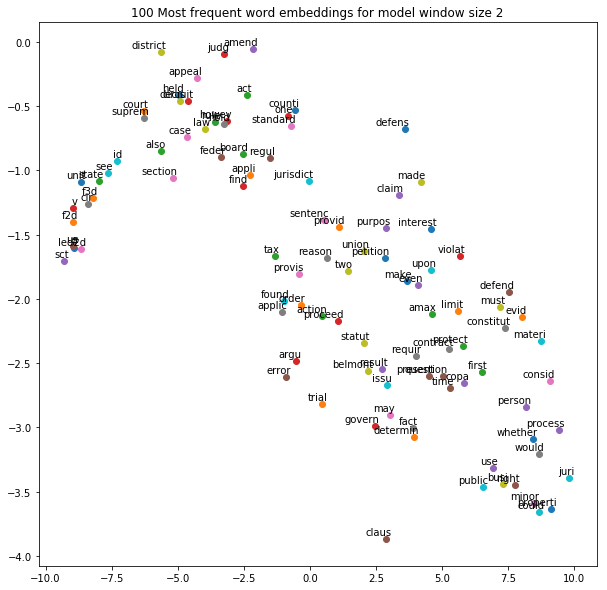

In [8]:
tsnePlot(freq_words, w2v_window2, "window size 2")

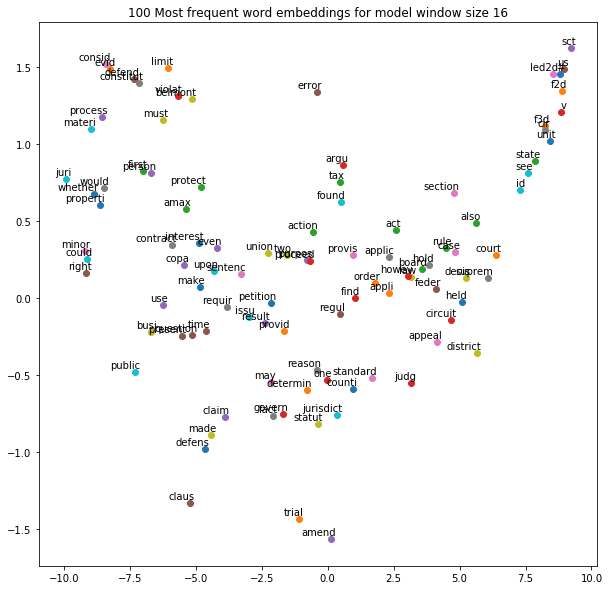

In [9]:
tsnePlot(freq_words, w2v_window16, "window size 16")

### 2. Train separate word embeddings for Republican and Democrat judges

In [10]:
def get_caseid(doc):
    return doc.split("_")[1].split('.')[0]
cases['caseid']=cases['id'].apply(get_caseid)
# Add the republican flag to the dataframe
def get_party(id):
    if id in case_metadata['caseid'].values:
        return case_metadata.loc[case_metadata['caseid']==id]['x_republican'].values[0]
    else:
        return "NA"
cases['x_republican']=cases['caseid'].apply(get_party)
cases.head()

,id,text,doc,normalized_doc,caseid,x_republican
187,1929_X3G5UO.txt,"DAVIS , Circuit Judge. These cases are brough...","( , DAVIS, ,, Circuit, Judge, ., These, cases,...","[davi, circuit, judg, case, brought, appeal, c...",X3G5UO,0
199,1929_X3GGHC.txt,"VAN ORSDEL , Associate Justice. A suit was br...","( , VAN, ORSDEL, ,, Associate, Justice, ., A, ...","[van, orsdel, associ, justic, suit, brought, s...",X3GGHC,NA
234,1930_X3GOD0.txt,"DIETRICH , Circuit Judge. In November, 1924, ...","( , DIETRICH, ,, Circuit, Judge, ., In, Novemb...","[dietrich, circuit, judg, novemb, #, appelle, ...",X3GOD0,1
253,1930_X3GRJ1.txt,"SWAN , Circuit Judge (after stating the facts...","( , SWAN, ,, Circuit, Judge, (, after, stating...","[swan, circuit, judg, state, fact, judgment, f...",X3GRJ1,NA
316,1932_X3IBA6.txt,"JAMES , District Judge. By this proceeding th...","( , JAMES, ,, District, Judge, ., By, this, pr...","[jame, district, judg, proceed, brought, revie...",X3IBA6,1


In [11]:
republicans = cases[cases['x_republican'] == 0]
republicans.head()

,id,text,doc,normalized_doc,caseid,x_republican
187,1929_X3G5UO.txt,"DAVIS , Circuit Judge. These cases are brough...","( , DAVIS, ,, Circuit, Judge, ., These, cases,...","[davi, circuit, judg, case, brought, appeal, c...",X3G5UO,0
877,1940_X3BAME.txt,"HOLMES , Circuit Judge. This is a contest ove...","( , HOLMES, ,, Circuit, Judge, ., This, is, a,...","[holm, circuit, judg, contest, proceed, insur,...",X3BAME,0
963,1941_X3BF4O.txt,"CLARK , Circuit Judge. Taxpayer maintained se...","( , CLARK, ,, Circuit, Judge, ., Taxpayer, mai...","[clark, circuit, judg, taxpay, maintain, sever...",X3BF4O,0
1069,1942_X40G2Q.txt,"GARRECHT , Circuit Judge. Joseph Galloway ent...","( , GARRECHT, ,, Circuit, Judge, ., Joseph, Ga...","[garrecht, circuit, judg, joseph, galloway, en...",X40G2Q,0
1223,1944_X481M1.txt,"GOODRICH , Circuit Judge. Robert Michael was ...","( , GOODRICH, ,, Circuit, Judge, ., Robert, Mi...","[goodrich, circuit, judg, robert, michael, con...",X481M1,0


In [12]:
democrats = cases[cases['x_republican'] == 1]
democrats.head()

,id,text,doc,normalized_doc,caseid,x_republican
234,1930_X3GOD0.txt,"DIETRICH , Circuit Judge. In November, 1924, ...","( , DIETRICH, ,, Circuit, Judge, ., In, Novemb...","[dietrich, circuit, judg, novemb, #, appelle, ...",X3GOD0,1
316,1932_X3IBA6.txt,"JAMES , District Judge. By this proceeding th...","( , JAMES, ,, District, Judge, ., By, this, pr...","[jame, district, judg, proceed, brought, revie...",X3IBA6,1
610,1936_X4AID4.txt,"SANBORN , Circuit Judge. Albert C. Tobin (her...","( , SANBORN, ,, Circuit, Judge, ., Albert, C.,...","[sanborn, circuit, judg, albert, c, tobin, her...",X4AID4,1
1139,1943_X47SM3.txt,"GARDNER , Circuit Judge. This is an appeal fr...","( , GARDNER, ,, Circuit, Judge, ., This, is, a...","[gardner, circuit, judg, appeal, preliminari, ...",X47SM3,1
2269,1961_X41R0Q.txt,"LEWIS , District Judge. This is an action to ...","( , LEWIS, ,, District, Judge, ., This, is, an...","[lewi, district, judg, action, recov, incom, t...",X41R0Q,1


In [13]:
w2v_window16_d = Word2Vec(democrats['normalized_doc'], size=100, window=2, min_count=10, workers=8)
w2v_window16_d.train(democrats['normalized_doc'], total_examples=len(cases['normalized_doc']), epochs=1)
#w2v_window16_d.similar_by_word("issu", topn=10)

(24622, 37603)

In [14]:
w2v_window16_r = Word2Vec(republicans['normalized_doc'], size=100, window=2, min_count=10, workers=8)
w2v_window16_r.train(republicans['normalized_doc'], total_examples=len(cases['normalized_doc']), epochs=1)

(31211, 46035)

In [15]:
# Get all adjectives in a document collection and print the most similar to a concept
def printSimilarAdjectivesToConcept(concept, df, w2v):
    adjectives = []
    def getAdj(doc):
        for word in doc:
            if nlp(word)[0].pos_ == 'ADJ':
                adjectives.append(word)

    df['normalized_doc'].apply(getAdj)
    adjectives = list(set(adjectives))
    similarities = []
    for adj in adjectives:
        if adj in w2v.wv.vocab:
            similarities.append(w2v.similarity(concept, adj))
        else:
            similarities.append(0.0)
    indicies_top_five = sorted(range(len(similarities)), key=lambda i: similarities[i])[-5:]
    print [adjectives[i] for i in indicies_top_five]

In [16]:
print w2v_window16_d.wv.vocab

{u'code': <gensim.models.keyedvectors.Vocab object at 0x140d85310>, u'consider': <gensim.models.keyedvectors.Vocab object at 0x140c0de50>, u'lack': <gensim.models.keyedvectors.Vocab object at 0x140c0de90>, u'month': <gensim.models.keyedvectors.Vocab object at 0x140c0ded0>, u'larus': <gensim.models.keyedvectors.Vocab object at 0x140c0df10>, u'signific': <gensim.models.keyedvectors.Vocab object at 0x140be3550>, u'go': <gensim.models.keyedvectors.Vocab object at 0x140d85350>, u'sct': <gensim.models.keyedvectors.Vocab object at 0x140bb68d0>, u'settlement': <gensim.models.keyedvectors.Vocab object at 0x140c0df90>, u'defraud': <gensim.models.keyedvectors.Vocab object at 0x140bc8dd0>, u'whose': <gensim.models.keyedvectors.Vocab object at 0x140bc8d90>, u'decid': <gensim.models.keyedvectors.Vocab object at 0x140be3590>, u'number': <gensim.models.keyedvectors.Vocab object at 0x140c18690>, u'system': <gensim.models.keyedvectors.Vocab object at 0x140d8c590>, u'tariff': <gensim.models.keyedvectors.

In [19]:
print w2v_window16_r.wv.vocab

{u'represent': <gensim.models.keyedvectors.Vocab object at 0x140e15f50>, u'code': <gensim.models.keyedvectors.Vocab object at 0x140e2b910>, u'consider': <gensim.models.keyedvectors.Vocab object at 0x140e15f90>, u'lack': <gensim.models.keyedvectors.Vocab object at 0x140e15fd0>, u'month': <gensim.models.keyedvectors.Vocab object at 0x140e1b050>, u'although': <gensim.models.keyedvectors.Vocab object at 0x140e3cc90>, u'rapid': <gensim.models.keyedvectors.Vocab object at 0x140e3c590>, u'signific': <gensim.models.keyedvectors.Vocab object at 0x140dbd350>, u'per': <gensim.models.keyedvectors.Vocab object at 0x140e2b190>, u'go': <gensim.models.keyedvectors.Vocab object at 0x140e2b950>, u'follow': <gensim.models.keyedvectors.Vocab object at 0x140d97cd0>, u'8e': <gensim.models.keyedvectors.Vocab object at 0x140e31b50>, u'request': <gensim.models.keyedvectors.Vocab object at 0x140e36310>, u'whose': <gensim.models.keyedvectors.Vocab object at 0x140d97810>, u'accus': <gensim.models.keyedvectors.Voc

In [17]:
print "Most similar adjectives to christian for democrats"
printSimilarAdjectivesToConcept('christian', democrats, w2v_window16_d)

Most similar adjectives to undercharg for democrats
[u'offic', u'relat', u'argu', u'materi', u'serious']


In [20]:
print "Most similar adjectives to christian for republicans"
printSimilarAdjectivesToConcept('christian', democrats, w2v_window16_r)

Most similar adjectives to legal for republicans
[u'key', u'subject', u'legal', u'indic', u'clear']


### 3. Causal inference method:  effect of text features on reversal (Hartford et al, 2017)

In [21]:
# Implement the Deep IV framework

# Make a feature set 
import nltk
terms = {}
for doc in cases['normalized_doc']:
    triword =  [t for t in nltk.trigrams(doc)]
    for trigram in triword:
        (token1, token2, token3) = trigram
        if nlp(token3)[0].pos_ == 'NOUN':
            if trigram in terms:
                terms[trigram]+=1
            else:
                terms[trigram]=1


In [22]:
# Make a dataframe with 20 features
num_features=20
sorted_terms = sorted(terms, key=terms.get, reverse=True)[:num_features]

vocab = set(x for x in sorted_terms)
print vocab
tr = {}

cleaned_freqs = []
ids=[]
index=0
for doc in cases['normalized_doc']:
    triword =  [t for t in nltk.trigrams(doc)]
    tr={}
    for trigram in triword:
        if trigram in vocab:
            if trigram in tr:
                tr[trigram]+=1
            else:
                tr[trigram]=1
    cleaned_freqs.append(tr)
    ids.append(cases['id'].iloc[index])
    index+=1
    
features = pd.DataFrame(cleaned_freqs)
features.head()

set([(u'#', u'#', u'sct'), (u'#', u'#', u'#'), (u'v', u'unit', u'state'), (u'f3d', u'#', u'#'), (u'#', u'f3d', u'#'), (u'f2d', u'#', u'#'), (u'#', u'f2d', u'#'), (u'#', u'us', u'#'), (u'#', u'sct', u'#'), (u'us', u'#', u'#'), (u'sct', u'#', u'#'), (u'#', u'led', u'#'), (u'unit', u'state', u'#'), (u'led2d', u'#', u'#'), (u'#', u'n', u'#'), (u'#', u'usc', u'#'), (u'#', u'fsupp', u'#'), (u'id', u'#', u'#'), (u'#', u'#', u'led2d'), (u'#', u'led2d', u'#')])


,"(#, #, #)","(#, #, led2d)","(#, #, sct)","(#, f2d, #)","(#, f3d, #)","(#, fsupp, #)","(#, led, #)","(#, led2d, #)","(#, n, #)","(#, sct, #)","(#, us, #)","(#, usc, #)","(f2d, #, #)","(f3d, #, #)","(id, #, #)","(led2d, #, #)","(sct, #, #)","(unit, state, #)","(us, #, #)","(v, unit, state)"
0,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0
2,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,7.0
4,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0


In [23]:
# fillna
features.fillna(0,inplace=True)
# normalize features to unit variance
normalized_df=features/features.std()
normalized_df.head()

,"(#, #, #)","(#, #, led2d)","(#, #, sct)","(#, f2d, #)","(#, f3d, #)","(#, fsupp, #)","(#, led, #)","(#, led2d, #)","(#, n, #)","(#, sct, #)","(#, us, #)","(#, usc, #)","(f2d, #, #)","(f3d, #, #)","(id, #, #)","(led2d, #, #)","(sct, #, #)","(unit, state, #)","(us, #, #)","(v, unit, state)"
0,0.950012,0.0,0.0,0.207923,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.198569,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1.492876,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.405826,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.709263,0.0,0.536678
2,0.000000,0.0,0.0,0.207923,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,1.764308,0.0,0.0,0.415846,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.127790,0.0,1.878374
4,0.678580,0.0,0.0,0.103962,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.063895,0.0,0.805017


In [24]:
# Link to reversed case
import csv
with open('/Users/paulinagrnarova/Desktop/RobotJudge/PS1/case_reversed.csv', mode='r') as infile:
    reader = csv.reader(infile)

    reversed_dict = dict((rows[0],rows[1]) for rows in reader)
def add_reversed(doc):
    return reversed_dict[doc.split("_")[1].split(".")[0]]

cases['reversed']=cases['id'].apply(add_reversed)
cases.head()

,id,text,doc,normalized_doc,caseid,x_republican,reversed
187,1929_X3G5UO.txt,"DAVIS , Circuit Judge. These cases are brough...","( , DAVIS, ,, Circuit, Judge, ., These, cases,...","[davi, circuit, judg, case, brought, appeal, c...",X3G5UO,0,0
199,1929_X3GGHC.txt,"VAN ORSDEL , Associate Justice. A suit was br...","( , VAN, ORSDEL, ,, Associate, Justice, ., A, ...","[van, orsdel, associ, justic, suit, brought, s...",X3GGHC,NA,1
234,1930_X3GOD0.txt,"DIETRICH , Circuit Judge. In November, 1924, ...","( , DIETRICH, ,, Circuit, Judge, ., In, Novemb...","[dietrich, circuit, judg, novemb, #, appelle, ...",X3GOD0,1,1
253,1930_X3GRJ1.txt,"SWAN , Circuit Judge (after stating the facts...","( , SWAN, ,, Circuit, Judge, (, after, stating...","[swan, circuit, judg, state, fact, judgment, f...",X3GRJ1,NA,0
316,1932_X3IBA6.txt,"JAMES , District Judge. By this proceeding th...","( , JAMES, ,, District, Judge, ., By, this, pr...","[jame, district, judg, proceed, brought, revie...",X3IBA6,1,0


In [25]:
# define the treatment, instrument and outcome
text_features_dict = {}
x_input = []
y_output = []
z_instrument = []

for feature in normalized_df.iterrows():
    x_input.append(feature[1])
for doc in cases['reversed']:
    y_output.append(int(doc))
for doc in cases['x_republican']:
    if doc=="NA": doc=0
    z_instrument.append(int(doc))

In [26]:
# prepare and save the data
x_input = np.array(x_input)    
y_output = np.array(y_output) 
z_instrument = np.array(z_instrument) 

pd.to_pickle(x_input,'x_input.pkl')
pd.to_pickle(y_output,'y_output.pkl')
pd.to_pickle(z_instrument,'z_instrument.pkl')

In [1]:
# load data
import pandas as pd
x_input = pd.read_pickle('x_input.pkl')  
y_output = pd.read_pickle('y_output.pkl')  
z_instrument = pd.read_pickle('z_instrument.pkl')  

In [2]:
# split the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test , z_train, z_test = train_test_split(x_input, y_output, z_instrument, test_size=0.2)

In [3]:
# First stage: Treatment network
# Implement mixture density network
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
import mdn # installed with pip install git+git://github.com/cpmpercussion/keras-mdn-layer.git#egg=keras-mdn-layer
N_HIDDEN = 2  # number of hidden units in the Dense layer
N_MIXES = 8  # number of mixture components
OUTPUT_DIMS = 20  # number of real-values predicted by each mixture component

output_size = 20 # the feature size
n_comp = 8
n_hidden = 2

# build model
firststage_model = Sequential()
firststage_model.add(Dense(n_hidden, batch_input_shape=(None, 1), activation='relu')) # 8x1 - z_train
firststage_model.add(mdn.MDN(output_size, n_comp))
# compile model
firststage_model.compile(loss=mdn.get_mixture_loss_func(output_size, n_comp), optimizer='sgd')
firststage_model.fit(z_train, x_train, epochs=10, batch_size=2, validation_data=(z_test, x_test))
firststage_model.summary()
# predict
pred_input = firststage_model.predict(z_instrument)
pred_train = firststage_model.predict(z_train)
pred_test = firststage_model.predict(z_test)

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/usr/local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item()

Instructions for updating:
Use tf.cast instead.
Train on 40 samples, validate on 10 samples
Epoch 1/10
40/40 [==============================] - 1s 35ms/step - loss: 33.5391 - val_loss: 25.6094
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 32.3581 - val_loss: 25.3567
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 30.5117 - val_loss: 24.8371
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 29.0451 - val_loss: 23.8659
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 26.7931 - val_loss: 21.4744
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 23.0790 - val_loss: 18.5628
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 20.0475 - val_loss: 16.2436
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 18.1531 - val_loss: 14.3740
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 17.5799 - val_loss: 19.5874
Epoch 1

In [4]:
# Second stage: Outcome network
# Implement a DNN with real valued output

# build model
secondstage_model = Sequential()
secondstage_model.add(Dense(units=32, activation='relu'))
secondstage_model.add(Dense(units=16, activation='relu'))
secondstage_model.add(Dense(units=1, activation='sigmoid'))
secondstage_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# compile and train model
secondstage_model.fit(pred_train, y_train, epochs=10, batch_size=2, validation_data=(pred_test, y_test))
secondstage_model.summary()
# predict
pred_output_y = secondstage_model.predict(pred_input)
pred_train_y = secondstage_model.predict(pred_train)
pred_test_y = secondstage_model.predict(pred_test)

Train on 40 samples, validate on 10 samples
Epoch 1/10
40/40 [==============================] - 1s 13ms/step - loss: 0.6381 - acc: 0.6750 - val_loss: 0.6103 - val_acc: 0.7000
Epoch 2/10
40/40 [==============================] - 0s 657us/step - loss: 0.6542 - acc: 0.6750 - val_loss: 0.6110 - val_acc: 0.7000
Epoch 3/10
40/40 [==============================] - 0s 1ms/step - loss: 0.6395 - acc: 0.6750 - val_loss: 0.6100 - val_acc: 0.7000
Epoch 4/10
40/40 [==============================] - 0s 1ms/step - loss: 0.6545 - acc: 0.6750 - val_loss: 0.6101 - val_acc: 0.7000
Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 0.6484 - acc: 0.6750 - val_loss: 0.6102 - val_acc: 0.7000
Epoch 6/10
40/40 [==============================] - 0s 901us/step - loss: 0.6489 - acc: 0.6750 - val_loss: 0.6100 - val_acc: 0.7000
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6447 - acc: 0.6750 - val_loss: 0.6099 - val_acc: 0.7000
Epoch 8/10
40/40 [=======================